In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostRegressor
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

focus on ensemble and boosting methods for time series forecasting models

In [39]:
df_16 = pd.read_csv("coin_gecko_2022-03-16.csv")
df_17 = pd.read_csv("coin_gecko_2022-03-17.csv")

In [8]:
df_16.head()

,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,BTC,40859.460000,0.022,0.030,0.055,3.539076e+10,7.709915e+11,2022-03-16
1,Ethereum,ETH,2744.410000,0.024,0.034,0.065,1.974870e+10,3.271044e+11,2022-03-16
2,Tether,USDT,1.000000,-0.001,-0.001,0.000,5.793497e+10,7.996516e+10,2022-03-16
3,BNB,BNB,383.430000,0.018,0.028,0.004,1.395854e+09,6.404382e+10,2022-03-16
4,USD Coin,USDC,0.999874,-0.001,0.000,-0.000,3.872274e+09,5.222214e+10,2022-03-16


Clean the data

In [40]:
df_16.isnull().sum()

coin          0
symbol        0
price         0
1h            3
24h           3
7d            3
24h_volume    3
mkt_cap       0
date          0
dtype: int64

In [41]:
df_16[df_16["1h"].isnull()==True].index, df_16[df_16["24h"].isnull()==True].index, df_16[df_16["7d"].isnull()==True].index, df_16[df_16["24h_volume"].isnull()==True].index

(Int64Index([310, 416, 472], dtype='int64'),
 Int64Index([310, 416, 472], dtype='int64'),
 Int64Index([310, 416, 472], dtype='int64'),
 Int64Index([310, 416, 472], dtype='int64'))

In [42]:
# remove rows with missing values
df_16 = df_16.drop([310, 416, 472])

In [14]:
df_16["price_7d"] = df_16["price"] + df_16["7d"]
df_16["price_24h"] = df_16["price"] + df_16["24h"]
df_16["price_1h"] = df_16["price"] + df_16["1h"]

In [15]:
df_16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 499
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coin        497 non-null    object 
 1   symbol      497 non-null    object 
 2   price       497 non-null    float64
 3   1h          497 non-null    float64
 4   24h         497 non-null    float64
 5   7d          497 non-null    float64
 6   24h_volume  497 non-null    float64
 7   mkt_cap     497 non-null    float64
 8   date        497 non-null    object 
 9   price_7d    497 non-null    float64
 10  price_24h   497 non-null    float64
 11  price_1h    497 non-null    float64
dtypes: float64(9), object(3)
memory usage: 66.6+ KB


Graph the price movement

In [18]:
def price_movement(coin_symbol):
    selected_coin = df_16[df_16.symbol == coin_symbol][["price_7d", "price_24h", "price_1h", "price"]]
    sns.lineplot(data=pd.melt(selected_coin), x="variable", y="value", color="red")
    plt.show()

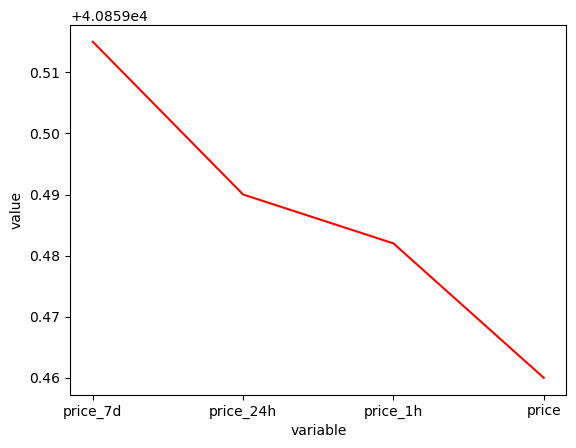

In [19]:
price_movement("BTC")

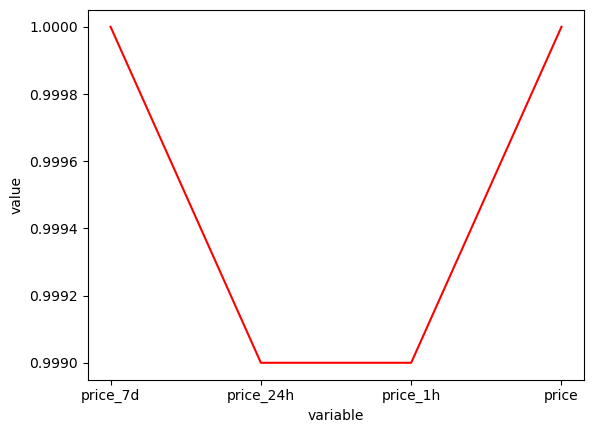

In [20]:
price_movement("USDT")

Modeling with Training and Testing Sets

In [21]:
df_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coin        500 non-null    object 
 1   symbol      500 non-null    object 
 2   price       500 non-null    float64
 3   1h          496 non-null    float64
 4   24h         496 non-null    float64
 5   7d          495 non-null    float64
 6   24h_volume  496 non-null    float64
 7   mkt_cap     500 non-null    float64
 8   date        500 non-null    object 
dtypes: float64(6), object(3)
memory usage: 35.3+ KB


In [43]:
# drop missing values
df_17 = df_17.dropna()

In [44]:
df_17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coin        495 non-null    object 
 1   symbol      495 non-null    object 
 2   price       495 non-null    float64
 3   1h          495 non-null    float64
 4   24h         495 non-null    float64
 5   7d          495 non-null    float64
 6   24h_volume  495 non-null    float64
 7   mkt_cap     495 non-null    float64
 8   date        495 non-null    object 
dtypes: float64(6), object(3)
memory usage: 38.7+ KB


In [45]:
X_train, y_train = df_16[["1h", "24h", "7d", "mkt_cap", "24h_volume"]], df_16["price"]
X_test, y_test = df_17[["1h", "24h", "7d", "mkt_cap", "24h_volume"]], df_17["price"]

In [123]:
xgb_model = xgb.XGBModel(learning_rate=0.001, reg_alpha=0.1, reg_lambda=0.01, random_state=42)
xgb_model.fit(X_train, y_train)

XGBModel(learning_rate=0.001, random_state=42, reg_alpha=0.1, reg_lambda=0.01)

In [124]:
y_pred = xgb_model.predict(X_test)
test_score = np.sqrt(np.mean((y_pred - y_test) ** 2))
print(f"RMSE: {test_score}")

RMSE: 4188.119103856213


In [111]:
catb_model = CatBoostRegressor(reg_lambda=10, verbose=1, random_state=42)
catb_model.fit(X_train, y_train)

0:	learn: 4576.9541902	total: 799us	remaining: 799ms
1:	learn: 4555.7487888	total: 1.69ms	remaining: 845ms
2:	learn: 4546.6045998	total: 2.33ms	remaining: 776ms
3:	learn: 4544.5488531	total: 3ms	remaining: 747ms
4:	learn: 4542.5553398	total: 3.63ms	remaining: 724ms
5:	learn: 4540.4551912	total: 4.23ms	remaining: 701ms
6:	learn: 4536.6417211	total: 4.8ms	remaining: 681ms
7:	learn: 4534.6567287	total: 5.39ms	remaining: 669ms
8:	learn: 4532.5049967	total: 5.98ms	remaining: 659ms
9:	learn: 4530.6161784	total: 6.23ms	remaining: 617ms
10:	learn: 4528.7016538	total: 6.85ms	remaining: 616ms
11:	learn: 4527.0232808	total: 7.48ms	remaining: 616ms
12:	learn: 4525.1394593	total: 8.08ms	remaining: 613ms
13:	learn: 4523.2896977	total: 8.39ms	remaining: 591ms
14:	learn: 4521.4104694	total: 9.04ms	remaining: 593ms
15:	learn: 4517.4629177	total: 9.79ms	remaining: 602ms
16:	learn: 4515.4571632	total: 10.4ms	remaining: 604ms
17:	learn: 4513.5449043	total: 10.8ms	remaining: 591ms
18:	learn: 4511.7175826	t

In [112]:
y_pred = catb_model.predict(X_test)
test_score = np.sqrt(np.mean((y_pred - y_test) ** 2))
print(F"RMSE: {test_score}")

RMSE: 4111.024347776174
